# Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

np.set_printoptions(linewidth = 200)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/My Drive/ML/'
train_features_file = base_path + 'preprocessed_train.csv'
train_labels_file = base_path + 'train_set_labels.csv'
test_features_file = base_path + 'preprocessed_test.csv'

In [ ]:
train_df = pd.read_csv(train_features_file)
labels_df = pd.read_csv(train_labels_file)
test_df = pd.read_csv(test_features_file)
results_df = pd.DataFrame()
results_df['id'] = test_df['id']
test_df=test_df.drop(['id'],axis=1)

# Preprocessing

In [ ]:
train_df.loc[train_df['public_meeting'] == False, 'public_meeting'] = 0
train_df.loc[train_df['public_meeting'] == True, 'public_meeting'] = 1

train_df.loc[train_df['permit'] == False, 'permit'] = 0
train_df.loc[train_df['permit'] == True, 'permit'] = 1

test_df.loc[test_df['public_meeting'] == False, 'public_meeting'] = 0
test_df.loc[test_df['public_meeting'] == True, 'public_meeting'] = 1

test_df.loc[test_df['permit'] == False, 'permit'] = 0
test_df.loc[test_df['permit'] == True, 'permit'] = 1

labels_df['status_group'].replace({'functional': 2, 'functional needs repair':1, 'non functional': 0}, inplace=True)
labels = labels_df['status_group']

In [ ]:
feature_columns = []
resolution = 0.3  
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.fit_transform(test_df)

# Define Model

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)
  plt.legend()

Loaded the plot_curve function.


In [ ]:
def create_model(feature_layer,my_learning_rate):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.4))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))      
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="categorical_crossentropy",
                 metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  
  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs, hist    

# Train sample model

In [ ]:
labels = to_categorical(labels, 3)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(train_df,labels,test_size=0.2,shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
11/11 [==============================] - 5s 354ms/step - loss: 0.8471 - accuracy: 0.6061 - precision: 0.6784 - recall: 0.5012 - val_loss: 0.6664 - val_accuracy: 0.7302 - val_precision: 0.7756 - val_recall: 0.6671
Epoch 2/150
11/11 [==============================] - 4s 323ms/step - loss: 0.6702 - accuracy: 0.7282 - precision: 0.7602 - recall: 0.6766 - val_loss: 0.6228 - val_accuracy: 0.7443 - val_precision: 0.7858 - val_recall: 0.6949
Epoch 3/150
11/11 [==============================] - 4s 318ms/step - loss: 0.6297 - accuracy: 0.7452 - precision: 0.7789 - recall: 0.6965 - val_loss: 0.6038 - val_accuracy: 0.7582 - val_precision: 0.7923 - val_recall: 0.7039
Epoch 4/150
11/11 [==============================] - 3s 316ms/step - loss: 0.6037 - accuracy: 0.7572 - precision: 0.7884 - recall: 0.7117 - val_loss: 0.5874 - val_accuracy: 0.7616 - val_precision: 0.7915 - val_recall: 0.7189
Epoch 5/150
11/11 [==============================] - 3s 317ms/step - loss: 0.5861 - accuracy: 0.7633

[0.9786743521690369,
 0.7696127891540527,
 0.7823368906974792,
 0.7478955984115601]

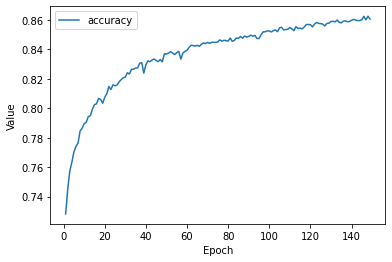

In [ ]:
learning_rate = 0.001
epochs = 150
batch_size = 4096
validation_split = 0.1

model = create_model(my_feature_layer,learning_rate)
epochs, hist = train_model(model, X_train, y_train, 
                           epochs, batch_size, validation_split)
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)
print("\n Evaluate the new model against the test set:")
model.evaluate(x=X_eval, y=y_eval, batch_size=batch_size)

# Train final model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
14/14 [==============================] - 6s 340ms/step - loss: 0.7769 - accuracy: 0.6638 - precision_1: 0.7102 - recall_1: 0.5774 - val_loss: 0.6502 - val_accuracy: 0.7384 - val_precision_1: 0.7581 - val_recall_1: 0.7106
Epoch 2/150
14/14 [==============================] - 4s 315ms/step - loss: 0.6453 - accuracy: 0.7364 - precision_1: 0.7687 - recall_1: 0.6871 - val_loss: 0.6138 - val_accuracy: 0.7487 - val_precision_1: 0.7774 - val_recall_1: 0.7114
Epoch 3/150
14/14 [==============================] - 4s 311ms/step - loss: 0.6153 - accuracy: 0.7491 - precision_1: 0.7784 - recall_1: 0.7075 - val_loss: 0.5980 - val_accuracy: 0.7535 - val_precision_1: 0.7874 - val_recall_1: 0.7000
Epoch 4/150
14/14 [==============================] - 4s 308ms/step - loss: 0.5980 - accuracy: 0.7557 - precision_1: 0.7855 - recall_1: 0.7147 - val_loss: 0.5839 - val_accuracy: 0.7618 - val_precision_1: 0.7920 - val_recall_1: 0.7076
Epoch 5/150
14/14 [==============================] - 4s 307ms/step -

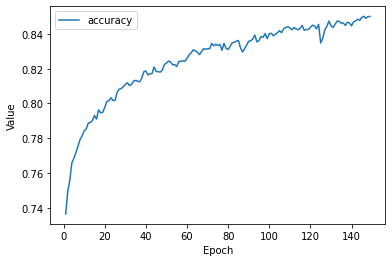

In [ ]:
learning_rate = 0.001
epochs = 150
batch_size = 4096
validation_split = 0.1
model = create_model(my_feature_layer,learning_rate)
epochs, hist = train_model(model, train_df, labels, 
                           epochs, batch_size, validation_split)
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
predictions = model.predict(test_df, batch_size=batch_size, verbose=1)
predictions = np.argmax(predictions, axis=1)
predictions=pd.DataFrame(predictions)

4/4 [==============================] - 0s 92ms/step


In [ ]:
predictions

,0
0,2
1,2
2,2
3,0
4,2
...,...
14845,2
14846,2
14847,2
14848,2


In [ ]:
predictions.replace({2:'functional', 1:'functional needs repair', 0:'non functional'}, inplace=True)

In [ ]:
results_df['status_group'] = predictions

In [ ]:
results_df

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
results_df.to_csv('results.csv',index=False)